In [1]:
# https://www.properati.com.ar/data
! wget -O ar_properties.csv.gz -q https://storage.googleapis.com/properati-data-public/ar_properties.csv.gz
! gzip -d -f ./ar_properties.csv.gz

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import sklearn as sk
from sklearn import model_selection
from sklearn import ensemble
from sklearn import metrics

import datetime

# Lectura de datos

In [2]:
df_properties = pd.read_csv('./ar_properties.csv', index_col="id")
df_apred = pd.read_csv('./a_predecir.csv', index_col="id")

In [129]:
df = df_properties.copy()
df_pred = df_apred.copy()

In [ ]:
df.head()

In [ ]:
df_pred.info()

In [ ]:
df.info()

# Análisis del conjunto de datos

In [151]:
df_m2 = df.loc[(df.price.notnull()) & (df.surface_covered.notnull()) & (df.l3.notnull()) & (df.surface_covered > 0)]

In [161]:
df_m2["m2"] = df_m2.price / df_m2.surface_covered

/tmp/ipykernel_79919/2211268282.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m2["m2"] = df_m2.price / df_m2.surface_covered


In [163]:
df_m2["m2"]

id
U3qdJMKXnOJm0Y1tWpnnfg==    3400.000000
gsQB/JzLxaQdBLfNcm/DMw==    3548.387097
SlPt6GJRjM+cO4rD3n3HFQ==    3500.000000
ZaH+6DXJ4MLM6QqZXhgWiw==    3260.869565
r7qrM5xaYo8QImSnqyKyYA==    2575.471698
                               ...     
kW2uYacPEyIcBykz/8rShA==    1388.888889
jaNlZUF/XN/I8PWilhABqw==    3600.000000
No3is+HhwUGlfgQfzsZbdg==    5185.185185
MHohdc05ZstJa30AbKyQEg==      11.851852
RYlWKNYAOPbDbHGoYD/PAA==       8.000000
Name: m2, Length: 105409, dtype: float64

In [166]:
df_m2[["l3","m2"]].groupby(["l3"]).mean().sort_values(by="m2",ascending=False)

,m2
l3,
Liniers,5333.008353
Mataderos,4034.258203
Puerto Madero,3836.116110
Villa Pueyrredón,3785.952511
Las Cañitas,3717.427826
Villa Urquiza,3609.443668
Agronomía,3544.476717
Belgrano,3322.178558
Palermo,3315.736110


In [169]:
df_pred[df_pred.l3 == "Mataderos"]

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,...,title,description,property_type,operation_type,details,additionals,services,l4,l5,l6
id,,,,,,,,,,,,,,,,,,,,,
134,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.503122,-34.660079,Argentina,Capital Federal,Mataderos,2.0,...,"Ercilla Al 6400 - PH en Venta en Mataderos, CA...",En venta PH de 2 ambientes en 1er piso por esc...,PH,Venta,"Superficie 54m2, Ambientes 2, Baños 1, Dormito...","Balcón, Terraza","Gas, Luz",NaN,NaN,NaN
818,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.509963,-34.653458,Argentina,Capital Federal,Mataderos,3.0,...,"Pilar Al 1400 - PH en Venta en Mataderos, CABA...",PH 3 AMBIENTES - OPORTUNIDAD!!!<br>- DOS DORMI...,PH,Venta,"Superficie 105m2, Ambientes 3, Baños 1, Dormit...","Aire Acondicionado, Patio, Aceptan Mascotas, T...","Gas, Luz",NaN,NaN,NaN


In [66]:
df_pred[df_pred.l3 == "Boca"]

,ad_type,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,...,title,description,property_type,operation_type,details,additionals,services,l4,l5,l6
id,,,,,,,,,,,,,,,,,,,,,
35,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.363134,-34.634496,Argentina,Capital Federal,Boca,3.0,...,"Hernandarias Al 1500 - PH en Venta en Boca, C...",Se trata de un Ph de 3ambientes al frente con ...,PH,Venta,"Superficie 66m2, Ambientes 3, Baños 1, Dormito...",Balcón,NaN,NaN,NaN,NaN
594,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.368129,-34.633506,Argentina,Capital Federal,Boca,6.0,...,Arzobispo Espinosa Al 1000 - PH en Venta en Bo...,PH 6 Ambientes en La Boca.<br>Living comedor.<...,PH,Venta,"Superficie 140m2, Ambientes 6, Baños 2, Dormit...","Patio, Terraza","Gas, Luz",NaN,NaN,NaN
715,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.364215,-34.637453,Argentina,Capital Federal,Boca,4.0,...,"Filiberto Al 1000 - PH en Venta en Boca, CABA...","Se trata de un hermoso PH de estilo, de 4 ambi...",PH,Venta,"Superficie 83m2, Ambientes 4, Baños 1, Dormito...",NaN,Luz,NaN,NaN,NaN
772,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.364459,-34.637280,Argentina,Capital Federal,Boca,3.0,...,Juan De Dios Filiberto Al 900 - PH en Venta en...,PH 3 amb impecable al frente sin expensas<br><...,PH,Venta,"Superficie 70m2, Ambientes 3, Baños 1, Dormito...",NaN,"Gas, Luz",NaN,NaN,NaN
968,Propiedad,2022-04-01,2022-04-01,2022-04-01,-58.363472,-34.633606,Argentina,Capital Federal,Boca,3.0,...,"Palos Al 200 - PH en Venta en Boca, CABA de 82...",Se trata de un 3 ambientes con patio mas un en...,PH,Venta,"Superficie 82m2, Ambientes 3, Baños 1, Dormito...",Aire Acondicionado,"Gas, Luz",NaN,NaN,NaN


In [77]:
df_pred.shape

(1087, 27)

In [84]:
df_pred[["l3","property_type"]].groupby(['l3']).count().sort_values(by='property_type', ascending=False).nlargest(23,"property_type")

,property_type
l3,
Palermo,205
Belgrano,110
Recoleta,97
Caballito,74
Villa Crespo,58
Almagro,57
Barracas,39
Flores,36
Nuñez,36


In [69]:
#analizamos los valores de las distintas variables
df.loc[df.l3 == "Boca",["l3","property_type","l2"]].groupby(['l3','property_type']).count().sort_values(by='l2', ascending=False)

l2
l3   property_type       
Boca Departamento     656
     PH                92
     Local comercial   84
     Casa              69
     Depósito          62
     Otro              58
     Lote              47
     Oficina           17
     Cochera            5

In [427]:
df_pred.l4.max()

34.819

In [428]:
df_pred.l4.min()

-38.0152022

# Tratamiento de nulls y outliers

## Longitud y Latitud

In [138]:
df = df.loc[df["l1"] == "Argentina"]

In [139]:
df = df.loc[df["l2"] == "Capital Federal"]

Coordenadas maximas CABA: \
Norte - (-34.531639, -58.464800)\
Este - (-34.62073349940953, -58.338011418419356)\
Oeste - (-34.61568853226109, -58.532674897063565)\
Sur - (-34.7058110012102, -58.4602477739537)\
\
Limites:\
Longitud - (-58.532674897063565, -58.338011418419356 )\
Latitud - (-34.7058110012102, -34.531639)

In [6]:
lon_min_max = (-58.532674897063565, -58.338011418419356 )
lat_min_max = (-34.7058110012102, -34.531639)

In [7]:
df_lon_lat = df.loc[df["l2"] == "Capital Federal"]

In [8]:
df_lon_lat.drop(df_lon_lat.loc[df_lon_lat["lat"].isnull() & df_lon_lat["lon"].isnull() & df_lon_lat["l3"].isnull()].index, inplace = True)
df_lon_lat = df_lon_lat[["lat", "lon", "l3"]]
df_lon_lat["lat_outlier"] = df_lon_lat.lat.apply(lambda x: 0 if (x > lat_min_max[0]) & (x < lat_min_max[1]) else 1  )
df_lon_lat["lon_outlier"] = df_lon_lat.lon.apply(lambda x: 0 if (x > lon_min_max[0]) & (x < lon_min_max[1]) else 1 )

In [9]:
df_lon_lat.drop(df_lon_lat.loc[(df_lon_lat.lat_outlier == 1) & (df_lon_lat.l3.isnull())].index, inplace = True)
out_lon_lat_ind = df_lon_lat.loc[(df_lon_lat.lat_outlier == 1) | (df_lon_lat.lon_outlier == 1)].index
df_lon_lat_out = df_lon_lat.loc[(df_lon_lat.lat_outlier == 1) | (df_lon_lat.lon_outlier == 1)]
df_lon_lat = df_lon_lat.loc[(df_lon_lat.lat_outlier == 0) & (df_lon_lat.lon_outlier == 0)]

In [10]:
l3_list = list(df_lon_lat.l3.unique())
l3_dict_lat = {}
l3_dict_lon = {}
for i in l3_list:
    l3_dict_lon[i] = df_lon_lat.loc[df_lon_lat.l3 == i, "lon"].mean()
    l3_dict_lat[i] = df_lon_lat.loc[df_lon_lat.l3 == i, "lat"].mean()

df_lon_lat_out["lon"] = df_lon_lat_out.l3.apply(lambda x:l3_dict_lon[x])
df_lon_lat_out["lat"] = df_lon_lat_out.l3.apply(lambda x:l3_dict_lat[x])

In [11]:
for ind in out_lon_lat_ind:
    df["lon"].loc[ind] = df_lon_lat_out["lon"].loc[ind]
    df["lat"].loc[ind] = df_lon_lat_out["lat"].loc[ind]   

/tmp/ipykernel_79919/3971525020.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["lon"].loc[ind] = df_lon_lat_out["lon"].loc[ind]
/tmp/ipykernel_79919/3971525020.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["lat"].loc[ind] = df_lon_lat_out["lat"].loc[ind]


## l3 - Barrio

Corregidas las longitudes y latitudes generamos un knn para predecir los barrios y completar l3

In [70]:
df_l3 = df[["lon","lat","l3"]]

df_l3.drop(df_l3.loc[df_l3["lon"].isnull()].index,inplace = True)
df_l3.drop(df_l3.loc[df_l3["lat"].isnull()].index,inplace = True)

df_test_l3 = df_l3.loc[df_l3["l3"].isnull()]

df_train_l3 = df_l3.loc[df_l3["l3"].notnull()]

/tmp/ipykernel_79919/2478595951.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_l3.drop(df_l3.loc[df_l3["lon"].isnull()].index,inplace = True)
/tmp/ipykernel_79919/2478595951.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_l3.drop(df_l3.loc[df_l3["lat"].isnull()].index,inplace = True)


In [71]:
X_l3 = df_train_l3[df_train_l3.columns.drop('l3')]
y_l3 = df_train_l3['l3']

#Partimos en entrenamiento y prueba 

for i in [1]:
    # Creamos el objeto del modelo
    neigh = sk.neighbors.KNeighborsClassifier(n_neighbors=i, n_jobs = -1)
    
    kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
    
    scores = []
    
    for train, test in kf.split(X_l3):
        
        X_train, X_test, y_train, y_test = X_l3.iloc[train], X_l3.iloc[test], y_l3[train], y_l3[test]
    
        # Entrenamos el modelo
        neigh.fit(X_train, y_train)
    
        # Predecimos
        y_pred_l3 = neigh.predict(X_test)
    
        # Medimos la performance de la predicción
        score = sk.metrics.accuracy_score(y_test, y_pred_l3)
        scores.append(score)
        #print(score)
    print(f"n_{i} {np.mean(scores)}")


n_1 0.8291631320588276


In [72]:
X_pred_l3 = df_test_l3[df_test_l3.columns.drop('l3')]

# Entrenamiento
neigh = sk.neighbors.KNeighborsClassifier(n_neighbors = 5, n_jobs = -1)

# Entrenamos el modelo
neigh.fit(X_train, y_train)

# predicción
df_test_l3["l3"] = neigh.predict(X_pred_l3)

/tmp/ipykernel_79919/599255535.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_l3["l3"] = neigh.predict(X_pred_l3)


In [73]:
df["l3"].loc[df["l3"].isnull()] = df_test_l3["l3"]

## Limpieza de otras columnas y lineas

In [195]:
df.drop(columns = ["ad_type","l4","l5", "l6", "created_on","start_date", "end_date","l1","l2","price_period","operation_type"], inplace = True )

/tmp/ipykernel_79919/2820527877.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns = ["ad_type","l4","l5", "l6", "created_on","start_date", "end_date","l1","l2","price_period","operation_type"], inplace = True )


In [144]:
df.dropna(subset=["price"], inplace = True)
df.dropna(subset=["currency"], inplace = True)

df.drop(df[df.l3 == "Catalinas"].index, inplace = True)

In [170]:
barrios_list = ['Palermo',
'Belgrano',
'Recoleta',
'Caballito',
'Villa Crespo',
'Almagro',
'Barracas',
'Flores',
'Nuñez',
'Villa Urquiza',
'Balvanera',
'Colegiales',
'San Telmo',
'Saavedra',
'Boedo',
'Villa Devoto',
'Monserrat',
'San Nicolás',
'Puerto Madero',
'Floresta',
'Villa del Parque',
'Paternal',
'San Cristobal']

df["barrios"] = df.l3.apply(lambda x: 1 if x in barrios_list else 0)

df = df.loc[df["barrios"] == 1]

df.drop(columns = "barrios", inplace = True)

In [197]:
df = df.loc[df["currency"] == "USD"]

df.drop(columns = ["currency"], inplace = True )

In [149]:
df["property_type_check"] = df.property_type.apply(lambda x: 1 if x in ("Departamento","PH") else 0)

df = df.loc[df["property_type_check"] == 1]

df.drop(columns = "property_type_check", inplace = True)

/tmp/ipykernel_79919/354315104.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["property_type_check"] = df.property_type.apply(lambda x: 1 if x in ("Departamento","PH") else 0)
/tmp/ipykernel_79919/354315104.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns = "property_type_check", inplace = True)


In [171]:
df.drop(df.loc[df["rooms"].isnull() & df["bedrooms"].isnull() & df["bathrooms"].isnull() & df["surface_total"].isnull() & df["surface_covered"].isnull()].index, inplace = True)

In [172]:
df_pred["rooms"].fillna(0, inplace = True)
df_pred["bedrooms"].fillna(0, inplace = True)
df_pred["bathrooms"].fillna(0, inplace = True)

In [173]:
df["rooms"].fillna(0, inplace = True)
df["bedrooms"].fillna(0, inplace = True)
df["bathrooms"].fillna(0, inplace = True)

In [174]:
df["surface_total"].loc[df["surface_total"].isnull() & df["surface_covered"] > 0] = df["surface_covered"].loc[df["surface_total"].isnull() & df["surface_covered"] > 0]

df["surface_total"].fillna(0, inplace = True)
df["surface_covered"].fillna(0, inplace = True)

/tmp/ipykernel_79919/3354645445.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["surface_total"].loc[df["surface_total"].isnull() & df["surface_covered"] > 0] = df["surface_covered"].loc[df["surface_total"].isnull() & df["surface_covered"] > 0]


In [175]:
df["bedrooms"].loc[df["bedrooms"] < 0 ] = abs(df["bedrooms"].loc[df["bedrooms"] < 0 ])

/tmp/ipykernel_79919/3611823614.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["bedrooms"].loc[df["bedrooms"] < 0 ] = abs(df["bedrooms"].loc[df["bedrooms"] < 0 ])


In [176]:
df["surface_total"].loc[df["surface_total"] < 0 ] = abs(df["surface_total"].loc[df["surface_total"] < 0 ])

/tmp/ipykernel_79919/3583135774.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["surface_total"].loc[df["surface_total"] < 0 ] = abs(df["surface_total"].loc[df["surface_total"] < 0 ])


In [177]:
df["surface_covered"].loc[df["surface_covered"] < 0 ] = abs(df["surface_covered"].loc[df["surface_covered"] < 0 ])

/tmp/ipykernel_79919/3604395483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["surface_covered"].loc[df["surface_covered"] < 0 ] = abs(df["surface_covered"].loc[df["surface_covered"] < 0 ])


In [178]:
df.drop(columns = ["title"], inplace = True)

In [179]:
df.drop(columns = ["lat","lon"], inplace = True)

In [180]:
df.drop(df.loc[df["price"]> 6000000].index, inplace=True)

In [181]:
df.drop(df[df.price < 15000.0].index,inplace = True)

In [182]:
df.drop_duplicates(inplace = True)

## Modifico el df_pred

In [183]:
df_pred.drop(columns = ["ad_type","l4","l5", "l6", "created_on"], inplace = True )
df_pred.drop(columns = ["l1","l2"], inplace = True )
df_pred.drop(columns = ["currency"], inplace = True )
df_pred.drop(columns = ["price_period"], inplace = True)
df_pred.drop(columns = "operation_type", inplace = True)
df_pred.drop(columns = ["start_date","end_date","services"], inplace = True)
df_pred.drop(columns = ["title","details"], inplace = True)

In [184]:
df_pred.drop(columns = ["lat","lon"], inplace = True)

# Feature Engineering

Concateno los dataframes para que tengan las mismas columnas y las variables categoricas esten alineadas

In [185]:
df_total = pd.concat([df,df_pred], axis=0)

## Additionals

Genero dummies con los additionals y lo agrego en el df

In [186]:
df_pred.additionals.fillna("zxzyzjz", inplace = True)
df_pred.additionals_split = df_pred.additionals.apply(lambda x: x.split(","))

/tmp/ipykernel_79919/910923671.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df_pred.additionals_split = df_pred.additionals.apply(lambda x: x.split(","))


In [187]:
additionals_list = df_pred.additionals_split.explode().unique()
additionals_list = [x.strip() for x in additionals_list]
additionals_list = list(dict.fromkeys(additionals_list))
additionals_list.append("subte")

In [188]:
df_total.description.fillna("sin_descripcion", inplace = True)

In [189]:
for additional in additionals_list:
    df_total[additional] = df_total.description.apply(lambda x: 1 if additional.lower() in x.lower() else 0)

In [190]:
df_total.drop(columns = "zxzyzjz", inplace = True)
df_total.drop(columns = "additionals", inplace = True)
df_total.drop(columns = "description", inplace = True)

## logaritmicas

In [44]:
df_total["lnrooms"] = df_total.rooms.apply(lambda x: x if x == 0 else np.log(x))

In [45]:
df_total["lnbedrooms"] = df_total.bedrooms.apply(lambda x: x if x == 0 else np.log(x))

In [46]:
df_total["lnsurface_covered"] = df_total.surface_covered.apply(lambda x: x if x == 0 else np.log(x))

In [47]:
df_total["lnsurface_total"] = df_total.surface_total.apply(lambda x: x if x == 0 else np.log(x))

## Dummies

In [191]:
df_total = pd.get_dummies(df_total, columns = ["property_type"])
df_total.l3.astype("category").cat.codes

id
gsQB/JzLxaQdBLfNcm/DMw==     2
SlPt6GJRjM+cO4rD3n3HFQ==    22
ZaH+6DXJ4MLM6QqZXhgWiw==    22
r7qrM5xaYo8QImSnqyKyYA==    22
VvLiigV+hn1PU9GIIinHDw==    22
                            ..
1083                         3
1084                        29
1085                        29
1086                        14
1087                        40
Length: 113317, dtype: int8

In [192]:
df_total.l3 = df_total.l3.astype("category").cat.codes

## Separo el dataframe nuevamente en df_pred y df

In [193]:
df = df_total[df_total.index.isin(df.index)]
df_pred = df_total[df_total.index.isin(df_pred.index)]

In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112230 entries, gsQB/JzLxaQdBLfNcm/DMw== to No3is+HhwUGlfgQfzsZbdg==
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   l3                          112230 non-null  int8   
 1   rooms                       112230 non-null  float64
 2   bedrooms                    112230 non-null  float64
 3   bathrooms                   112230 non-null  float64
 4   surface_total               112230 non-null  float64
 5   surface_covered             112230 non-null  float64
 6   price                       112230 non-null  float64
 7   Aceptan Mascotas            112230 non-null  int64  
 8   Terraza                     112230 non-null  int64  
 9   Pileta                      112230 non-null  int64  
 10  Seguridad                   112230 non-null  int64  
 11  SUM                         112230 non-null  int64  
 12  Laundry                     112230 n

# Modelización

In [199]:
X = df[df.columns.drop('price')]
y = df['price']

for n_estimators in [50,100]:
    for max_depth in [12,15]:     

## Tienen que usar RandomForestRegressor si o si o si. Pueden cambiar los parámetros
#n_estimators = 5000
#max_depth = 5

        reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, n_jobs=-1, random_state=42)

        scores = []
        kf = sk.model_selection.KFold(n_splits=10, shuffle=True, random_state=42)
        for train, test in kf.split(X):
            X_train, X_test, y_train, y_test = X.iloc[train], X.iloc[test], y[train], y[test]
        
            # Entrenamos el modelo
            reg.fit(X_train, y_train)
        
            # Predecimos
            y_pred = reg.predict(X_test)
        
            # Medimos la performance de la predicción
            score = sk.metrics.mean_squared_error(y_test, y_pred, squared=False)
            scores.append(score)
        print(f"max_depth:{max_depth} - mean: {np.mean(scores)} sd: {np.std(scores)}")
        
    #print(f"n_{n_estimators} - mean: {np.mean(scores)} sd: {np.std(scores)}")

max_depth:12 - mean: 113148.39506836099 sd: 7704.591916431513
max_depth:15 - mean: 106610.0148922002 sd: 8486.250539982817
max_depth:12 - mean: 113202.12492918146 sd: 7577.005307063255
max_depth:15 - mean: 106278.36921624615 sd: 8222.257549660844


## Predicción para Kaggle


In [200]:
# quedate con las mismas columnas que ar_properties
X_pred = df_pred[X.columns]
X_train = X
y_train = y

In [201]:
# los mejores hiperparámetros encontrados antes
n_estimators = 100
max_depth = 15

# Entrenamiento
reg = sk.ensemble.RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42, n_jobs=-1)

# Entrenamos el modelo
reg.fit(X_train, y_train)

# predicción
df_pred["price"] = reg.predict(X_pred)

/tmp/ipykernel_79919/2319193158.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pred["price"] = reg.predict(X_pred)


In [202]:
# Grabo la solución
df_pred[["price"]].to_csv("solucion.csv")

## Importancia de las variables

In [203]:
importances = reg.feature_importances_
#
# Sort the feature importance in descending order
#
sorted_indices = np.argsort(importances)[::-1]

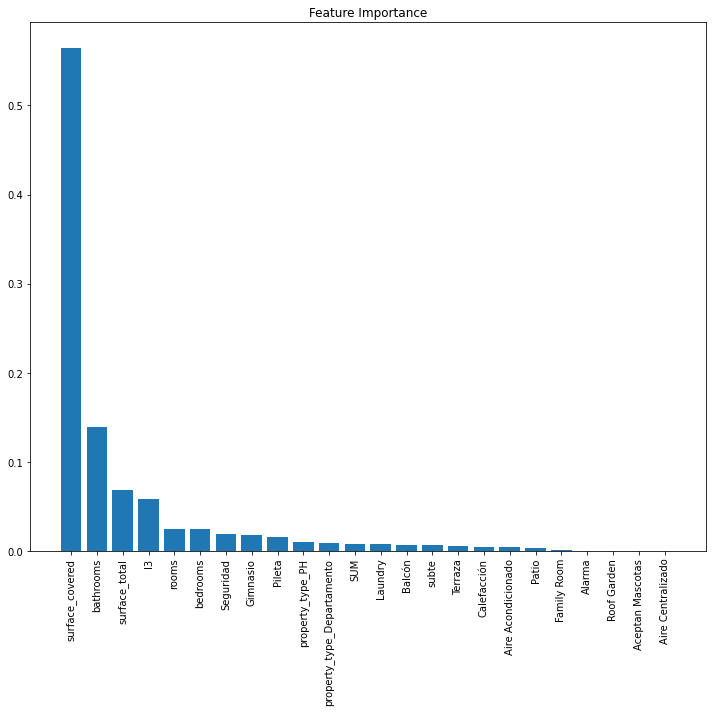

In [204]:
import matplotlib.pyplot as plt

f,a = plt.subplots(figsize=(10,10))
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), importances[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()